In [1]:
# importing useful libraries
import numpy as np
import tensorflow as tf
import random as python_random

# setting random seed for result reproducibility
np.random.seed(1)
python_random.seed(12)
tf.random.set_seed(123)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Metric

from sklearn.metrics import fbeta_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
mnist = tf.keras.datasets.mnist # downloading the dataset
# unpacking the training and testing set
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print()
print('Training features have shape: {}, while labels have shape{}'.format(train_images.shape, train_labels.shape))
print('Testing features have shape: {}, while labels have shape{}'.format(test_images.shape, test_labels.shape))

class_labels = np.unique(train_labels)
print("There are {} classes in the dataset. They are {}".format(len(class_labels), class_labels))


Training features have shape: (60000, 28, 28), while labels have shape(60000,)
Testing features have shape: (10000, 28, 28), while labels have shape(10000,)
There are 10 classes in the dataset. They are [0 1 2 3 4 5 6 7 8 9]


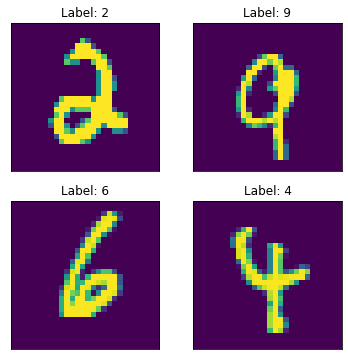

In [3]:
fig = plt.figure(figsize=(6, 6))
random_labels = np.random.choice(class_labels, size=4, replace=False)
for ind in range(len(random_labels)):
  random_ind = np.random.choice([i for i in range(len(train_labels)) if train_labels[i] == random_labels[ind]])
  ax = fig.add_subplot(2, 2, ind+1)
  plt.imshow(train_images[random_ind])
  plt.title("Label: {}".format(train_labels[random_ind]))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.show()

In [4]:
# re-scaling the data
train_images = train_images / 255
test_images = test_images / 255

# converting the labels to binary labels where 1 is an even number while 0 is an odd number
binary_train_labels = np.array([[float(label)] for label in train_labels%2 == 0])
binary_test_labels = np.array([[float(label)] for label in test_labels%2 == 0])

# storing the even and odd labels of the training set to seperate variables
even_indices_train = np.arange(binary_train_labels.shape[0])[binary_train_labels.flatten() == 1]
odd_indices_train = np.arange(binary_train_labels.shape[0])[binary_train_labels.flatten() == 0]


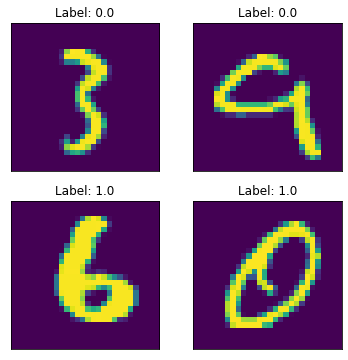

In [5]:
fig = plt.figure(figsize=(6, 6))

random_odd_labels = np.random.choice(list(range(1, 10, 2)), size=2, replace=False)
random_even_labels = np.random.choice(list(range(0, 10, 2)), size=2, replace=False)

for ind in range(len(random_odd_labels)+len(random_even_labels)):
  if ind < 2:
    random_ind = np.random.choice([i for i in odd_indices_train if train_labels[i] == random_odd_labels[ind]])
  else:
    random_ind = np.random.choice([i for i in even_indices_train if train_labels[i] == random_even_labels[ind-2]])

  ax = fig.add_subplot(2, 2, ind+1)
  plt.imshow(train_images[random_ind])
  plt.title("Label: {}".format(binary_train_labels[random_ind][0]))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

plt.show()

In [6]:
def eager_binary_fbeta(ytrue, ypred, beta=1.0, threshold=0.5):
  ypred = np.array(ypred >= threshold, dtype=np.float32)

  return fbeta_score(ytrue, ypred, beta)

In [7]:
def binary_fbeta(ytrue , ypred, beta=1, threshold=0.5, epsilon=1e-7):
    # epsilon is set so as to avoid division by zero error
    
    beta_squared = beta**2 # squaring beta

    # casting ytrue and ypred as float dtype
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)

    # setting values of ypred greater than the set threshold to 1 while those lesser to 0
    ypred = tf.cast(tf.greater_equal(ypred, tf.constant(threshold)), tf.float32)

    tp = tf.reduce_sum(ytrue*ypred) # calculating true positives
    predicted_positive = tf.reduce_sum(ypred) # calculating predicted positives
    actual_positive = tf.reduce_sum(ytrue) # calculating actual positives
    
    precision = tp/(predicted_positive+epsilon) # calculating precision
    recall = tp/(actual_positive+epsilon) # calculating recall
    
    # calculating fbeta
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    return fb

In [8]:
def build_model(start=512, metrics=binary_fbeta, run_eagerly=False, lr=1e-3):
    model = Sequential() # initializes a sequential model

    # adding three layers where a filter size is half of the preceding filter size
    for _ in range(3):
      model.add(Conv2D(filters=512, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
      start //= 2

    model.add(Flatten()) # flattens the layer

    model.add(Dense(1, activation='sigmoid')) # ouput layer

    opt = Adam(lr=lr) # initializes an optimizer

    # compling model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metrics], run_eagerly=run_eagerly)
    
    return model

In [9]:
eager_binary_model = build_model(metrics=eager_binary_fbeta, run_eagerly=True)
eager_binary_model.fit(x=train_images.reshape(-1, 28, 28, 1), y=binary_train_labels, batch_size=128, epochs=3, validation_split=0.25, shuffle=False);

Epoch 1/3
352/352 [==============================] - 87s 247ms/step - loss: 0.1130 - eager_binary_fbeta: 0.9526 - val_loss: 0.0489 - val_eager_binary_fbeta: 0.9829
Epoch 2/3
352/352 [==============================] - 85s 241ms/step - loss: 0.0445 - eager_binary_fbeta: 0.9847 - val_loss: 0.0378 - val_eager_binary_fbeta: 0.9869
Epoch 3/3
352/352 [==============================] - 85s 240ms/step - loss: 0.0331 - eager_binary_fbeta: 0.9878 - val_loss: 0.0412 - val_eager_binary_fbeta: 0.9851


In [10]:
binary_model = build_model()
binary_model.fit(x=train_images.reshape(-1, 28, 28, 1), y=binary_train_labels, batch_size=128, epochs=3, validation_split=0.25, shuffle=False);

Epoch 1/3
352/352 [==============================] - 69s 196ms/step - loss: 0.1116 - binary_fbeta: 0.9538 - val_loss: 0.0523 - val_binary_fbeta: 0.9808
Epoch 2/3
352/352 [==============================] - 68s 193ms/step - loss: 0.0470 - binary_fbeta: 0.9832 - val_loss: 0.0432 - val_binary_fbeta: 0.9845
Epoch 3/3
352/352 [==============================] - 68s 192ms/step - loss: 0.0344 - binary_fbeta: 0.9881 - val_loss: 0.0432 - val_binary_fbeta: 0.9853


In [11]:
# predicting the testing set
binary_ypred = binary_model.predict(test_images.reshape(-1, 28, 28, 1))

# one_hot encoding predictions 
binary_ypred = np.array(binary_ypred >= 0.5, dtype=np.float32)

print('Shape of testing labels is {}'.format(binary_test_labels.shape))
print('Shape of predicted testing set is {}'.format(binary_ypred.shape))
print()
print('f1_score of prediction using binary_fbeta is {}'.format(binary_fbeta(binary_test_labels, binary_ypred).numpy()))
print('f1_score of prediction using scikit-learn f1_score  is {}'.format(fbeta_score(binary_test_labels, binary_ypred, beta=1)))

# storing the even and odd labels of the testing set to seperate variables
even_indices_test = np.arange(binary_test_labels.shape[0])[binary_test_labels.flatten() == 1]
odd_indices_test = np.arange(binary_test_labels.shape[0])[binary_test_labels.flatten() == 0]

Shape of testing labels is (10000, 1)
Shape of predicted testing set is (10000, 1)

f1_score of prediction using binary_fbeta is 0.9886792302131653
f1_score of prediction using scikit-learn f1_score  is 0.9886792452830189


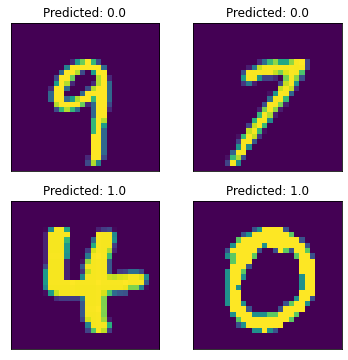

In [12]:
fig = plt.figure(figsize=(6, 6))

random_odd_labels = np.random.choice(list(range(1, 10, 2)), size=2, replace=False)
random_even_labels = np.random.choice(list(range(0, 10, 2)), size=2, replace=False)

for ind in range(len(random_odd_labels)+len(random_even_labels)):
  if ind < 2:
    random_ind = np.random.choice([i for i in odd_indices_test if test_labels[i] == random_odd_labels[ind]])
  else:
    random_ind = np.random.choice([i for i in even_indices_test if test_labels[i] == random_even_labels[ind-2]])
    
  ax = fig.add_subplot(2, 2, ind+1)
  plt.imshow(test_images[random_ind])
  plt.title("Predicted: {}".format(binary_ypred[random_ind][0]))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

plt.show()

In [13]:
class StatefullBinaryFBeta(Metric):
  def __init__(self, name='state_full_binary_fbeta', beta=1, threshold=0.5, epsilon=1e-7, **kwargs):
    # initializing an object of the super class
    super(StatefullBinaryFBeta, self).__init__(name=name, **kwargs)

    # initializing state variables
    self.tp = self.add_weight(name='tp', initializer='zeros') # initializing true positives 
    self.actual_positive = self.add_weight(name='fp', initializer='zeros') # initializing actual positives
    self.predicted_positive = self.add_weight(name='fn', initializer='zeros') # initializing predicted positives

    # initializing other atrributes that wouldn't be changed for every object of this class
    self.beta_squared = beta**2 
    self.threshold = threshold
    self.epsilon = epsilon

  def update_state(self, ytrue, ypred, sample_weight=None):
    # casting ytrue and ypred as float dtype
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)

    # setting values of ypred greater than the set threshold to 1 while those lesser to 0
    ypred = tf.cast(tf.greater_equal(ypred, tf.constant(self.threshold)), tf.float32)
        
    self.tp.assign_add(tf.reduce_sum(ytrue*ypred)) # updating true positives atrribute
    self.predicted_positive.assign_add(tf.reduce_sum(ypred)) # updating predicted positive atrribute
    self.actual_positive.assign_add(tf.reduce_sum(ytrue)) # updating actual positive atrribute

  def result(self):
    self.precision = self.tp/(self.predicted_positive+self.epsilon) # calculates precision
    self.recall = self.tp/(self.actual_positive+self.epsilon) # calculates recall

    # calculating fbeta
    self.fb = (1+self.beta_squared)*self.precision*self.recall / (self.beta_squared*self.precision + self.recall + self.epsilon)
    
    return self.fb

  def reset_states(self):
    self.tp.assign(0) # resets true positives to zero
    self.predicted_positive.assign(0) # resets predicted positives to zero
    self.actual_positive.assign(0) # resets actual positives to zero

In [14]:
statefull_binary_fbeta = StatefullBinaryFBeta() # initializes a stateful binary_fbeta object
binary_model = build_model(metrics=statefull_binary_fbeta) # builds model

# fitting model
binary_model.fit(x=train_images.reshape(-1, 28, 28, 1), y=binary_train_labels, batch_size=128, epochs=3, validation_split=0.25, shuffle=False);

Epoch 1/3
352/352 [==============================] - 68s 194ms/step - loss: 0.1150 - state_full_binary_fbeta: 0.9538 - val_loss: 0.0482 - val_state_full_binary_fbeta: 0.9829
Epoch 2/3
352/352 [==============================] - 68s 193ms/step - loss: 0.0470 - state_full_binary_fbeta: 0.9833 - val_loss: 0.0396 - val_state_full_binary_fbeta: 0.9865
Epoch 3/3
352/352 [==============================] - 68s 192ms/step - loss: 0.0338 - state_full_binary_fbeta: 0.9881 - val_loss: 0.0372 - val_state_full_binary_fbeta: 0.9877


In [15]:
m = StatefullBinaryFBeta() # initializes a stateful binary_fbeta object
n_size = 20

# creating random binary true and predicted labels
arr_true = list(np.random.choice([0, 1], size=n_size))
arr_pred = list(np.random.choice([0, 1], size=n_size))

m.update_state(arr_true, arr_pred)
print('Intermediate result for stateful binary fbeta is: {}'.format(float(m.result())))
print('Intermediate result using scikit-learn fbeta is: {}'.format(fbeta_score(arr_true, arr_pred, beta=1)))
print()

increment_size = 20 

# creating random binary true and predicted labels to add to the old ones
a1 = list(np.random.choice([0, 1], size=increment_size))
a2 = list(np.random.choice([0, 1], size=increment_size))

m.update_state(a1, a2) # updating using our stateful binary fbeta object
print('Final result for stateful binary fbeta is {}:'.format(float(m.result())))

# adding a1 and a2 to arr_true and arr_pred respectively to form our new array
arr_true.extend(a1)
arr_pred.extend(a2)

print('Final result using scikit-learn fbeta is: {}'.format(fbeta_score(arr_true, arr_pred, beta=1)))

Intermediate result for stateful binary fbeta is: 0.5454545021057129
Intermediate result using scikit-learn fbeta is: 0.5454545454545454

Final result for stateful binary fbeta is 0.5652173161506653:
Final result using scikit-learn fbeta is: 0.5652173913043478
